# Tide gauges of the Dutch Coast
This notebook gathers details of the six main tide gauges of Rijkswaterstaat along the Dutch Coast. On overview is given on the location of these six stations. The different stations are elaborated in more detail below.

<ol>
  <li><a href="#DELFZL">Delfzijl</a></li>
  <li><a href="#DENHDR">Den Helder</a></li>
  <li><a href="#HARLGN">Harlingen</a></li>
  <li><a href="#HOEKVHLD">Hoek van Holland</a></li>
  <li><a href="#IJMDBTHVN">IJmuiden</a></li>
  <li><a href="#VLISSGN">Vlissingen</a></li>
</ol>

Extra information about the tide gauges can be found at the following locations:
- An overview of all Dutch tide gauges can be found at <a href="https://waterinfo.rws.nl/#!/kaart/waterhoogte-t-o-v-nap/">waterinfo.rws.nl</a>. 
- An overview of all tide gauges that deliver annual and monthly averages is available from <a href="http://www.psmsl.org">psmsl</a>.
- An overview of all tide gauges that deliver realtime data is available from <a href="http://uhslc.soest.hawaii.edu">University of Hawaii</a>


### Metadata

* Version: 
* Project: KPP Kustbeleid
* Author: Fedor Baart
* Reviewer:


In [1]:
# io
import zipfile
import io
import bisect
import logging

# Import packages
import numpy as np
import pandas as pd

# download, formats and projections
import netCDF4
import pyproj
import requests
import geojson
import rtree
import owslib.wcs
import osgeo.osr
import rasterio

# rendering
import mako.template
import IPython.display

# plotting
import bokeh.models
import bokeh.tile_providers
import bokeh.plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec
import matplotlib.colors

%matplotlib inline
bokeh.plotting.output_notebook()

Loading BokehJS ...

# Datasets
We use several external datasets. These are availble from public url's. 
The subsoil information is available from <a href="https://www.dinoloket.nl/">dinoloket.nl</a>. Part of the information about the Dutch tide gauges is available from  <a href="https://waterwebservices.rijkswaterstaat.nl">water webservices</a> at Rijkswaterstaat. The height information is available from Rijkswaterstaat's <a href="https://geoservices.rijkswaterstaat.nl/geoweb_silverlight/?Viewer=NAPinfo">geoweb viewer</a>, which is only viewable through silverlight. There is however a direct access to the data through <a href="https://geodata.nationaalgeoregister.nl/napinfo/wfs">the WFS server</a> at the nationaalgeoregister.nl. There are some images and technical drawings available on <a href="https://www.rijkswaterstaat.nl/formulieren/aanvraagformulier-servicedesk-data.aspx">request</a> at Rijkswaterstaat . 


In [2]:
# the files needed for this analysis
# dino, information about the subsoil >= -50m
dino_url = 'http://dinodata.nl/opendap/GeoTOP/geotop.nc'
# ddl, the data distributie laag
ddl_url = 'https://waterwebservices.rijkswaterstaat.nl/METADATASERVICES_DBO/OphalenCatalogus/'
# Dutch ordnance system
nap_url = 'https://geodata.nationaalgeoregister.nl/napinfo/wfs'
# Web coverage service for NAP.
ahn_url = 'http://geodata.nationaalgeoregister.nl/ahn2/wcs'
# The data from psmsl.org
psmsl_url = 'http://www.psmsl.org/data/obtaining/rlr.annual.data/rlr_annual.zip'

# Projections
The datasets mentioned above use different geospatial projections. The data from the water webservices is available in <a href="http://spatialreference.org/ref/epsg/25831/">UTM zone 31N on the ETRS89 geoid</a>. The local coordinate system is the Rijksdriehoekstelsel, which is availble <a href="http://spatialreference.org/ref/epsg/7415">with</a> and <a href="http://spatialreference.org/ref/epsg/28992">without</a> a reference to the vertical Coordinate System NAP.
Data is also transformed to the <a href="http://spatialreference.org/ref/epsg/4326">WGS84</a> and <a href="http://spatialreference.org/ref/epsg/3857">Web Mercator</a> projections. Note that we use the proj4 software here for the projection. Formally the RDNAPTrans software provides the translation between the RD and other coordinate system, but this software is only available on <a href="https://formulieren.kadaster.nl/aanvragen_rdnaptrans2008">request<a/>. 

In [3]:
# These are not used.
# Using osgeo.osr is an alternative to pyproj.
# They can give different results if EPSG tables are not up to date
# or if the proj version does not support datum transformations (>4.6.0)
wgs84 = osgeo.osr.SpatialReference()
wgs84.ImportFromEPSG(4326)
rd = osgeo.osr.SpatialReference()
rd.ImportFromEPSG(28992)
rdnap = osgeo.osr.SpatialReference()
rdnap.ImportFromEPSG(7415)
webm = osgeo.osr.SpatialReference()
webm.ImportFromEPSG(3857)
etrs89_utm31n = osgeo.osr.SpatialReference()
etrs89_utm31n.ImportFromEPSG(25831)
etrs89_utm31n2rd = osgeo.osr.CoordinateTransformation(etrs89_utm31n, rd)
etrs89_utm31n2wgs84 = osgeo.osr.CoordinateTransformation(etrs89_utm31n, wgs84)
etrs89_utm31n2webm = osgeo.osr.CoordinateTransformation(etrs89_utm31n, webm)

# We use pyproj
wgs84 = pyproj.Proj(init='epsg:4326')
rd = pyproj.Proj(init='epsg:28992')
rdnap = pyproj.Proj(init='epsg:7415')
webm = pyproj.Proj(init='epsg:3857')
etrs89_utm31n = pyproj.Proj(init='epsg:25831')

# if pyproj is old, give an error
if str(wgs84.proj_version) < "4.60":
    logging.error("""pyproj version {} does not support datum transformations. Use osgeo.osr, example above.""".format(wgs84.proj_version))

# Schematic representation of tide gauge station. 
The dataset below contains a manual annotation of the tide gauge schematics. The tide gauge schematics (shown below) were obtained through personal communication with Rijkswaterstaat. The dataset contains the following fields:

- location: Name of station
- psmsl_id: ID from PSMSL
- ddl_id: ID in data distributielaag (DDL)
- foundation_low: lowest point of foundation, read from tide gauge design (m relative to NAP)
- station_low: lowest point of station, read from tide gauge design  (m relative to NAP
- station_high: highest point of station, read from tide gauge design (m relative to NAP)
- nulpaal: station has a nulpaal (station is directly connected to NAP reference point)
- summary: description of tide gauge,
- img: image from CIV

This information is presented, in combination with the other information at the end of this document.

In [4]:
# this is information collected manual

main_stations = [
    {
        "ddl_id": "DELFZL",
        "location": "Delfzijl",
        "psmsl_id": 24,
        "foundation_low": -20,
        "station_low": 1.85,
        "station_high": 10.18,
        "nulpaal": 0,
        "rlr2nap": lambda x: x - (6978-155),
        "summary": "The tidal measurement station in Delfzijl is located in the harbour of Delfzijl. Category 'Peilmeetstation'. The station has a main building with a foundation on a steel round pole (inner width = 2.3m, outer width 2.348m) reaching to a depth of -20m NAP. The Building is placed in the harbour and is connected to the main land by means of a steel stairs towards a quay. Which has also a foundation on steel poles. Peilbout is inside the construction attached to the wall. Every ten minutes the water level relative to NAP is measured. Between -4 and -5 m depth concrete seals of the underwater chamber. ",
        "img": "http://www.openearth.nl/sealevel/static/images/DELFZL.jpg",
        "autocad": "http://a360.co/2s8ltK7",      
        "links": []
    },
    {
        "ddl_id": "DENHDR",
        "location": "Den Helder",
        "psmsl_id": 23,
        "foundation_low": -5,
        "station_low": 5,
        "station_high": 8.47,
        "nulpaal": 1,
        "rlr2nap": lambda x: x - (6988-42),
        "summary": "This station is located in the dike of Den Helder. The station has a pipe through the dike towards the sea for the measurement of the water level. The inlet of this pipe is at -3.25m NAP. There is a seperate construction for the ventilation of the main building. Furthermore the peilbout is located outside the main building at the opposite side of the dike. The main construction has a foundation of steel sheet pilings forming a rectangle around the measurement instruments. Between -4 and -5 m depth concrete seals of the underwater chamber. ",
        "img": "http://www.openearth.nl/sealevel/static/images/DENHDR.jpg",
        "autocad": "http://a360.co/2sYyitj",
        "links": []
    },
    {
        "ddl_id": "HARLGN", 
        "location": "Harlingen",
        "psmsl_id": 25,
        "foundation_low": -5.4,
        "station_low": 5.55,
        "station_high": 8.54,
        "nulpaal": 1,
        "rlr2nap": lambda x: x - (7036-122),
        "summary": "The tidal station in Harlingen is located in a harbour on top of a boulevard. A pipe is going from the station at a depth of -2.56m NAP towards the sea. The inlet of the pipe is protected by a construction, so as to reduce the variations by the wave impact. The Main building has a foundation of a steel sheet pilings construction (rectangle inner dimensions 2.53 by 2.27m^2) surrounding the measurement instruments.",
        "img": "http://www.openearth.nl/sealevel/static/images/DELFZL.jpg",
        "autocad": "http://a360.co/2sYfFFX",
        "links": []
    },
    {
        "ddl_id": "HOEKVHLD", 
        "location": "Hoek van Holland",
        "psmsl_id": 22,
        "foundation_low": -3.3,
        "station_low": 5.27,
        "station_high": 9.05,
        "nulpaal": 0,
        "rlr2nap": lambda x:x - (6994 - 121),
        "summary": "The station in Hoek van Holland is located beside the Nieuwe Waterweg near the river mouth into the North Sea. The reference pole is situated outside the main building on the main land. The main building is connected to the main land by a steel bridge. The foundation of the main building is on steel poles. The building is a concrete structure reaching to a depth of -3.0 m NAP. This entire thing is enough for the measurement instruments to be placed inside. And the underwater chamber is then, in contrary to the other stations within the main building. The entire concrete structure has a foundation of multiple sheet piles. These are 8 concrete plates (8-sided) with a length of 14.1m. ",
        "img": "http://www.openearth.nl/sealevel/static/images/HOEKVHLD.jpg",
        "autocad": "http://a360.co/2uqAgAs",
        "links": []
    },
    {
        "ddl_id": "IJMDBTHVN", 
        "location": "IJmuiden",
        "psmsl_id": 32,
        "foundation_low": -13,
        "station_low": 4.2,
        "station_high": 10.35,
        "nulpaal": 0,
        "rlr2nap": lambda x: x - (7033-83),
        "summary": "IJmuiden is located on the northern part of the marina in IJmuiden, near a breakwater. The main building is situated in the water and is connected by a steel stairs and bridge with the main land. The foundation of this building consists out a round steel sheet pile. The under water chamber is closed of with a concrete slab between -3.75m NAP and - 4.5m NAP. The sheet pile is extended to a depth of -13m NAP. IJmuiden has a GPS (GNSS) station attached to it.",
        "img": "http://www.openearth.nl/sealevel/static/images/IJMDBTHVN.jpg",
        "autocad": "http://a360.co/2sZ4Nrn",
        "links": [
            {
                "href": "http://gnss1.tudelft.nl/dpga/station/Ijmuiden.html",
                "name": "GNSS info"
            }
        ]
    },
    {
        "ddl_id": "VLISSGN",
        "location": "Vlissingen",
        "psmsl_id": 20,
        "foundation_low": -17.6,
        "station_low": 2.5,
        "station_high": 9,
        "nulpaal": 0,
        "rlr2nap": lambda x: x - (6976-46),
        "summary": "This station is located at a quay in Vlissingen, near the outer harbour. The foundation is a steel sheet pile reaching to a depth of -17.6m NAP, having a width of 2.2m (outer width). Inside this pile are the measurement instruments. The under water chamber is sealed of with a concrete slab reaching from -4.0 m NAP to -5.0 m NAP. The station has a GPS (GNSS) device attached.",
        "img": "http://www.openearth.nl/sealevel/static/images/VLISSGN.jpg",
        "autocad": "http://a360.co/2sZ4Nrn",
        "links": [
            {
                "href": "http://gnss1.tudelft.nl/dpga/station/Vlissingen.html",
                "name": "GNSS info"
            }
        ]
    }
]

In [5]:
# convert the data to a dataframe (table)
station_data = pd.DataFrame.from_records(main_stations)
station_data = station_data.set_index('ddl_id')
station_data[['location', 'psmsl_id', 'nulpaal']]

,location,psmsl_id,nulpaal
ddl_id,,,
DELFZL,Delfzijl,24,0
DENHDR,Den Helder,23,1
HARLGN,Harlingen,25,1
HOEKVHLD,Hoek van Holland,22,0
IJMDBTHVN,IJmuiden,32,0
VLISSGN,Vlissingen,20,0


# PSMSL records
The <a href="www.psmsl.org">PSMSL</a> keeps a record of information of all tide gauges. They are responsible for the collection of the monthly and annual mean sea-level data from the global network of tide gauges. The PSMSL is based in Liverpool at the National Oceanography Centre (NOC). There are also two parties working on the collection of realtime measurements. These can be found at the <a href="http://uhslc.soest.hawaii.edu/">University of Hawaii sea-level center</a>. Unfortunately the Dutch data is not in there. Dutch data in PSMSL is also often lagging. You have to ask Rijkswaterstaat to deliver the data to PSMSL, or if that does not work, ask PSMSL to ask Rijkswaterstaat for the data. 
You can also manually calculate the mean sea-levels from the 10minute data, but this does not always match up with the "formal" figures. We download the information from the PSMSL and use it to define the revised local reference level.

The analysis of the tide gauge data itself is done in the <a href="dutch-monitor.ipynb">sea-level monitor</a>.

In [6]:
# read information from the psmsl
zf = zipfile.ZipFile('../data/psmsl/rlr_annual.zip')
records = []
for station in main_stations:
    filename = 'rlr_annual/RLR_info/{}.txt'.format(station['psmsl_id'])
    img_bytes = zf.read('rlr_annual/RLR_info/{}.png'.format(station['psmsl_id']))
    img = plt.imread(io.BytesIO(img_bytes))
    record = {
        "ddl_id": station["ddl_id"],
        "psmsl_info": zf.read(filename).decode(),
        "psmsl_img": img
    }
    records.append(record)
psmsl_df = pd.DataFrame.from_records(records).set_index("ddl_id")
station_data = pd.merge(station_data, psmsl_df, left_index=True, right_index=True)
station_data[['psmsl_info']]

,psmsl_info
ddl_id,
DELFZL,Add 6.815m to data up to 2005 to refer to RLR ...
DENHDR,Add 6.929m to data up to 2005 to refer to RLR ...
HARLGN,Add 6.907m to data up to 2005 to refer to RLR ...
HOEKVHLD,Add 6.845m to data up to 2005 to refer to RLR ...
IJMDBTHVN,Add 6.929m to data up to 2005 to refer to RLR ...
VLISSGN,Add 6.900m to data up to 2005 to refer to RLR ...


In [7]:
# read the grid of the dino dataset
dino = netCDF4.Dataset(dino_url, 'r')
x_dino = dino.variables['x'][:]
y_dino = dino.variables['y'][:]
z_dino = dino.variables['z'][:]
# lookup z index of -15m
z_min_idx = np.searchsorted(z_dino, -15)
# lookup litho at z index
z_min = dino.variables['lithok'][..., z_min_idx]
# keep the mask so we can look for close points

# fill value is sometimes a string, not sure why
fill_value = int(dino.variables['lithok']._FillValue)
mask_dino = np.ma.masked_equal(z_min, fill_value).mask


## Water webservices @ Rijkswaterstaat
The water data from Rijkswaterstaat is available from a <a href="https://waterwebservices.rijkswaterstaat.nl/METADATASERVICES_DBO/OphalenCatalogus">url</a>. The webservice is a bit unorthodox. The requests are all in Dutch and it does not follow a common REST or any other familiar protocol. So make sure you read through the <a href="http://www.rijkswaterstaat.nl/rws/opendata/DistributielaagWebservices-SUM-2v7.pdf">documentation</a>, which is only available in pdf format.
The main thing that we need here are the x and y coordinates (in ETRS89 UTM31N). 


In [8]:
# get station information from DDL
request = {
    "CatalogusFilter": {
        "Eenheden": True,
        "Grootheden": True,
        "Hoedanigheden": True
    }
}
resp = requests.post(ddl_url, json=request)
result = resp.json()

df = pd.DataFrame.from_dict(result['LocatieLijst'])
df = df.set_index('Code')
# note that there are two stations for IJmuiden. 
# The station was moved from the sluices to outside of the harbor in 1981.
ids = ['DELFZL', 'DENHDR', 'HARLGN', 'HOEKVHLD', 'IJMDBTHVN', 'IJMDNDSS', 'VLISSGN']

# make a copy so we can add things
stations_df = df.loc[ids].copy()
# this drops IJMDNSS
stations_df = pd.merge(stations_df, station_data, left_index=True, right_index=True)
stations_df[['Naam', 'X', 'Y']]

,Naam,X,Y
DELFZL,Delfzijl,761899.770960,5.915790e+06
DENHDR,Den Helder,617198.393684,5.869731e+06
HARLGN,Harlingen,661021.585505,5.894519e+06
HOEKVHLD,Hoek van Holland,576917.669784,5.759136e+06
IJMDBTHVN,IJmuiden buitenhaven,605633.035699,5.813598e+06
VLISSGN,Vlissingen,541425.983215,5.699182e+06


To be able to display the data on a map. Data is transformed into the projections mentioned above. The Web Mercator is used to display data on a map. 

In [9]:
# compute coordinates in different coordinate systems
stations_df['x_rd'], stations_df['y_rd'] = pyproj.transform(
    etrs89_utm31n, 
    rd, 
    list(stations_df.X), 
    list(stations_df.Y)
)
stations_df['lon'], stations_df['lat'] = pyproj.transform(
    etrs89_utm31n, 
    wgs84, 
    list(stations_df.X), 
    list(stations_df.Y)
)
stations_df['x_webm'], stations_df['y_webm'] = pyproj.transform(
    etrs89_utm31n, 
    webm, 
    list(stations_df.X), 
    list(stations_df.Y)
)
stations_df[['lat', 'lon']]

,lat,lon
DELFZL,53.326355,6.933123
DENHDR,52.964359,4.744990
HARLGN,53.175634,5.409342
HOEKVHLD,51.977574,4.119881
IJMDBTHVN,52.462326,4.554823
VLISSGN,51.442311,3.596057


## DINO
The Geologische Dienst Nederland (GDN), part of TNO, has created a database of subsoil data.
This database is refered to as Data en Informatie van de Nederlandse Ondergrond (DINO). 
We use this dataset to gather information about the subsoil at the location of the tide gauge.
More information can be found at the <a href="http://www.dinoloket.nl/">DINO</a> website.

Here we show a map of the coverage of the lithography at -15m. 

In [10]:
# We define some colors so they look somewhat natural. 
# The colors are based on images of the corresponding soil type.
# It is unknown what litho class 4 is. 

colors = {
    0: '#669966', # Above ground
    1: '#845F4C', # Peat
    2: '#734222', # Clay
    3: '#B99F71', # Sandy Clay
    4: '#ff0000', # litho 4
    5: '#E7D1C1', # Fines 
    6: '#c2b280', # Intermediate
    7: '#969CAA', # Coarse
    8: '#D0D6D6', # Gravel
    9: '#E5E5DB', # Shells,
    10: '#EEEEEE' # Undefined
    
}
labels = {
    0: "Above ground",
    1: "Peat",
    2: "Clay",
    3: "Sandy clay",
    4: "lithoclass 4",
    5: "Fine sand",
    6: "Intermediate fine sand",
    7: "Coarse sand",
    8: "Gravel",
    9: "Shells",
    10: "Undefined"
}

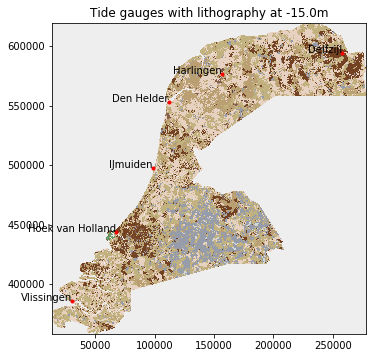

In [11]:
# Create a map of tide gauges with lithography at deep level
colors_rgb = [
    matplotlib.colors.hex2color(val) 
    for val 
    in colors.values()
]
# lookup colors
img = np.take(colors_rgb, np.ma.masked_values(z_min, -127).filled(10).T, axis=0)
fig, ax = plt.subplots(figsize=(8, 8/1.4))
ax.imshow(
    img, 
    origin='bottom', 
    extent=(x_dino[0], x_dino[-1], y_dino[0], y_dino[-1])
)
ax.plot(stations_df.x_rd, stations_df.y_rd, 'r.')
for name, row in stations_df.iterrows():
    ax.text(row.x_rd, row.y_rd, row.location, horizontalalignment='right')
_ = ax.set_title('Tide gauges with lithography at {}m'.format(z_dino[z_min_idx]))

For each tide gauge the corresponding lithography is looked up at a location close the tide gauge. For some tide gauges this means that the litography is not on water where the tide gauge is or the other way around. 

In [12]:
# this part looks up the nearest location of DINO and looksup the lithography in that location

Y_dino, X_dino = np.meshgrid(y_dino, x_dino)
# Lookup the closest points in the dino database

# closest location
dino_idx = []
lithos = []
for code, station in stations_df.iterrows():
    # compute the distance
    x_idx = np.argmin(np.abs(station.x_rd - x_dino))
    y_idx = np.argmin(np.abs(station.y_rd - y_dino))
    # closest point, can also use a kdtree
    # store it
    dino_idx.append((x_idx, y_idx))
    lithok = dino.variables['lithok'][x_idx, y_idx, :]
    litho = pd.DataFrame(data=dict(z=z_dino, litho=lithok))
    lithos.append(litho)

# convert to array
dino_idx = np.array(dino_idx)
# store the tuples
stations_df['dino_idx'] = list(dino_idx)
# lookup x,y
stations_df['x_dino'] = x_dino[dino_idx[:, 0]]
stations_df['y_dino'] = y_dino[dino_idx[:, 1]]
stations_df['x_dino_webm'], stations_df['y_dino_webm'] = pyproj.transform(
    rd, 
    webm, 
    list(stations_df['x_dino']), 
    list(stations_df['y_dino'])
)
stations_df['lithok'] = lithos
stations_df[['lithok', 'x_dino', 'y_dino']]


,lithok,x_dino,y_dino
DELFZL,litho z 0 7.0 -50.0 1 7.0...,258000,594400
DENHDR,litho z 0 7.0 -50.0 1 7.0...,111800,553200
HARLGN,litho z 0 5.0 -50.0 1 5.0...,156500,576600
HOEKVHLD,litho z 0 5.0 -50.0 1 5.0...,67900,444000
IJMDBTHVN,litho z 0 5.0 -50.0 1 5.0...,98400,497500
VLISSGN,litho z 0 3.0 -50.0 1 3.0...,30500,385200


# NAP info
The NAP is the local reference level for the Netherlands. The data is downloaded from georegister because the napinfo is not accessible through an api. The data is shown in the overview at the end of this document.

In [13]:

features = geojson.load(open('../data/rws/nap/public/napinfo.json'))
index = rtree.Rtree()
for i, feature in enumerate(features['features']):
    # broken element (invalid coordinates)
    if feature['properties']['gml_id'] == "nappeilmerken.37004":
        continue
    index.add(i, tuple(feature['geometry']['coordinates']), feature)


In [14]:
# index.nearest(statio)
records = []
for ddl_id, station in stations_df.iterrows():
    closest = []
    for item in index.nearest((station.x_rd, station.y_rd), num_results=5, objects=True):
        feature = item.object
        feature['properties']['x_webm'], feature['properties']['y_webm'] = pyproj.transform(
            rd, 
            webm, 
            feature['properties']['x_rd'],
            feature['properties']['y_rd']
        )
        feature['properties']['distance'] = np.sqrt(
            (station.x_rd - float(feature['properties']['x_rd']))**2 +
            (station.y_rd - float(feature['properties']['y_rd']))**2
        )
            
        closest.append(feature)
    records.append({
        "ddl_id": ddl_id,
        "nap": closest
    })
nap_df = pd.DataFrame.from_records(records).set_index('ddl_id')

stations_df = pd.merge(stations_df, nap_df, left_index=True, right_index=True)
stations_df[['nap']]

,nap
DELFZL,"[{'type': 'Feature', 'geometry': {'type': 'Poi..."
DENHDR,"[{'type': 'Feature', 'geometry': {'type': 'Poi..."
HARLGN,"[{'type': 'Feature', 'geometry': {'type': 'Poi..."
HOEKVHLD,"[{'type': 'Feature', 'geometry': {'type': 'Poi..."
IJMDBTHVN,"[{'type': 'Feature', 'geometry': {'type': 'Poi..."
VLISSGN,"[{'type': 'Feature', 'geometry': {'type': 'Poi..."


## AHN
For each tide gauge we lookup the AHN of the ground. This is not defined for most stations because they are in the water. 

In [15]:
wcs = owslib.wcs.WebCoverageService(ahn_url, version='1.0.0')

def ahn_for_station(station):
    # can't import this before pyproj are set
    

    # wms.getfeatureinfo()
    delta = 1e-6
    resp = wcs.getCoverage(
        'ahn2:ahn2_05m_int', 
        bbox=(station['lon']-delta, station['lat']-delta, station['lon']+delta, station['lat']+delta),
        crs='EPSG:4326',
        width=1,
        height=1,
        format='geotiff'
    )
    with open('result.tiff', 'wb') as f:
        f.write(resp.read())
    with rasterio.open('result.tiff') as f:
        data = f.read()[0]
    ahn_ma = np.ma.masked_outside(data, -100, 100)
    return ahn_ma[0, 0]

ahns = []
for ddl_id, station in stations_df.iterrows():
    ahn = ahn_for_station(station)
    ahns.append({
        "ddl_id": ddl_id,
        "ahn": ahn
    })
ahn_df = pd.DataFrame.from_records(ahns).set_index('ddl_id')
stations_df = pd.merge(stations_df, ahn_df, left_index=True, right_index=True)
stations_df[['ahn']]

,ahn
DELFZL,--
DENHDR,--
HARLGN,--
HOEKVHLD,--
IJMDBTHVN,3.67
VLISSGN,4.93


## Map of the main tide gauges
The map below shows some of the information that we have collected so far. The locations of the tide gauges. The locations of the closest point in the DINO source and the location of the closest points where the NAP is determined.

In [16]:
# Now we plot the mapping between the DINO, NAP locations and the tide gauge locations

# Save data in datasource
stations_cds = bokeh.models.ColumnDataSource.from_df(
    stations_df[['x_webm', 'y_webm', 'x_dino_webm', 'y_dino_webm', 'Naam', 'lat', 'lon']].copy()
)

# Plot map with locations of stations and nearest data of dino_loket
p = bokeh.plotting.figure(tools='pan, wheel_zoom, box_zoom', x_range=(320000, 780000), y_range=(6800000, 7000000))

p.axis.visible = False
p.add_tile(bokeh.tile_providers.CARTODBPOSITRON)
# two layers
c1 = p.circle(x='x_webm', y='y_webm', size=20, source=stations_cds, legend='Tide gauges')
c2 = p.circle(x='x_dino_webm', y='y_dino_webm', size=10, source=stations_cds, color='orange', legend='Nearest location dinodata')
for ddl_id, station in stations_df.iterrows():
    for nap_feature in station['nap']:
        c = p.circle(
            x=nap_feature['properties']['x_webm'], 
            y=nap_feature['properties']['y_webm'],
            size=3,
            color='black',
            legend='nap point near tide gauge'
        )
# tools, so you can inspect and zoom in
p.add_tools(
    bokeh.models.HoverTool(
        renderers =[c1],
        tooltips=[
            ("name", "@Naam"),
            ("Lon, Lat", "(@lat, @lon)"),
        ]
    )
)


In [17]:
bokeh.plotting.show(p)

# Subsidence
The subsidence rates are based on the report from M. Hijma and H. Kooij (2017). They have updated the subsidence models and created a multi-model average for the tectonic movement. The analysis of the NAP history can be found under this repository in the folder analysis/subsidence. 

In [18]:
subsidence_df = pd.read_csv('../data/deltares/subsidence.csv').set_index('id')
nap_df = pd.read_csv('../data/deltares/subsidence_nap.csv').set_index('id')
subsidence_df.merge(nap_df, left_index=True, right_index=True)
stations_df.merge(subsidence_df, left_index=True, right_index=True)
subsidence_df

,Tectonic [cm/year],Autocompaction [cm/year],Isostacy [cm/year],Settlement [cm],Water extraction [cm],Salt extraction [cm],Gas extraction [cm],Expected water extraction [cm],Expected salt extraction [cm],Expected gas extraction [cm],Subsidence 1890-2017 [cm],Expected subsidence 2017-2050
id,,,,,,,,,,,,
VLISSGN,0.0005,0.000,-0.025,0,0,0,0,0,0,0,-3.1115,-0.8085
HOEKVHLD,-0.0010,-0.007,-0.035,0,0,0,-2,0,0,-1,-7.4610,-2.4190
IJMDBTHVN,-0.0060,-0.008,-0.040,0,0,0,0,0,0,0,-6.8580,-1.7820
DENHDR,-0.0020,-0.004,-0.050,0,0,0,0,0,0,0,-7.1120,-1.8480
HARLGN,-0.0060,-0.004,-0.055,0,0,0,0,0,0,0,-8.2550,-2.1450
DELFZL,0.0008,0.000,-0.045,0,0,0,-23,0,0,-10,-28.6134,-11.4586


# Overview per station
In this part of the report we summarize all the information per tide gauge. We use a template to generate a report. All the information that is presented is calculated above. If you want to reproduce this information download the notebook, install the relevant depencies, for example using anaconda and run the notebook. Some data that is used offline can be downloaded using the makefiles in the `data` directory. 
We also create a plot for each station. Notice that some of the subsoil information does not align with the tide gauge. This is due to the mismatch of the tide gauge location on side and the subsoil measurements and subsoil grid points on the other side. So please interpret with care.

In [19]:
template = """
<%!
f3 = lambda x: "{:.3f}".format(float(x))
f0 = lambda x: "{:.0f}".format(float(x))
%>

<h2>${station['location']} <a id="${station.index}"></a></h2>

<style>
.right.template {
  float: right;
}
.template img {
  max-width: 300px !important;
}
</style>
<figure class="right template" >
    <img src="${station['img']}" />
    <figcaption>Photo of tide gauge at ${station['location']}, &copy; CIV, RWS</figcaption>
</figure>

<dl>
<dt>Location (lat, lon)</dt>
<dd>${station['lat'] | f3}, ${station['lon'] | f3}</dd>
<dt>Location (Rijksdriehoek)</dt>
<dd>${station['x_rd'] | f0}, ${station['y_rd'] | f0}</dd>
<dt>PSMSL-ID</dt>
<dd><a href="http://www.psmsl.org/data/obtaining/stations/${station['psmsl_id']}.php">${station['psmsl_id']}</a></dd>
<dt>Description</dt>
<dd>${station['summary']}</dd>
<dt>History</dt>
<dd><pre>${station['psmsl_info']}</pre></dd>
<dt>Nap info (public)</dt>
<dd><pre>
% for nap_feature in station['nap']:
${nap_feature['properties']['pub_tekst']} @ ${nap_feature['properties']['nap_hoogte']} (class: ${nap_feature['properties']['orde']}, distance: ${nap_feature['properties']['distance'] | f0}m)
% endfor
</pre></dd>
</dl>
<h2>Subsidence info</h2>
These are the estimated subsidence rates, based on the NAP history analysis in this repository and on the subsidence report of Hijma (2017). 
${subsidence.to_html()}
Other relevant links:
- <a href='http://a360.co/2s8ltK7'>Autocad drawing</a> of the construction.
"""

In [20]:
T = mako.template.Template(text=template)

def summary(station):
    return IPython.display.Markdown(
        T.render(
            station=stations_df.loc[station], 
            subsidence=pd.DataFrame(subsidence_df.loc[station])
        )
    )

In [21]:
def plot_station(code, stations_df=stations_df):
    station = stations_df.loc[code]
    
    # filter out masked data (no known litho)
    litho_ma = np.ma.masked_invalid(station['lithok']['litho'])
    litho = litho_ma[~litho_ma.mask]
    z = station['lithok']['z'][~litho_ma.mask]

    foundation_low = np.ma.masked_invalid(station['foundation_low'])
    station_low = np.ma.masked_invalid(station['station_low'])
    station_high = np.ma.masked_invalid(station['station_high'])

    fig = plt.figure(figsize=(13, 8))
    gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
    ax1 = plt.subplot(gs[0])
    ax1.bar(
        np.zeros_like(z), 
        np.gradient(z), 
        0.8, 
        bottom=z,
        color=[colors[i] for i in litho]
    )    
    
    ax1.plot((0, 0), [foundation_low, station_low], 'k', lw=5, alpha=0.5)
    ax1.plot([0, 0], [station_low, station_high], 'k', lw=15, alpha=0.5)
    ax1.axhline(0, color='b', ls='--')
    ax1.set_title(('station ' + station.Naam))
    ax1.set_xlim(-0.1, 0.1)
    ax1.set_ylim(-50, 20)
    ax1.set_xticks([])
    ax1.set_ylabel('[m] relative to NAP')

    # plot in the 2nd axis to generate a legend
    ax2 = plt.subplot(gs[1])
    for label in labels:
        if label == 4:
            continue
        ax2.plot(0, 0, color=colors[label], label=labels[label])
    ax2.plot(0, 0, color='b', label='0m NAP', ls='--')
    ax2.legend(loc='center')
    ax2.axis('off')




<h2>Delfzijl <a id="Index(['Coordinatenstelsel', 'Locatie_MessageID', 'Naam', 'X', 'Y', 'autocad',
       'foundation_low', 'img', 'links', 'location', 'nulpaal', 'psmsl_id',
       'rlr2nap', 'station_high', 'station_low', 'summary', 'psmsl_img',
       'psmsl_info', 'x_rd', 'y_rd', 'lon', 'lat', 'x_webm', 'y_webm',
       'dino_idx', 'x_dino', 'y_dino', 'x_dino_webm', 'y_dino_webm', 'lithok',
       'nap', 'ahn'],
      dtype='object')"></a></h2>

<style>
.right.template {
  float: right;
}
.template img {
  max-width: 300px !important;
}
</style>
<figure class="right template" >
    <img src="http://www.openearth.nl/sealevel/static/images/DELFZL.jpg" />
    <figcaption>Photo of tide gauge at Delfzijl, &copy; CIV, RWS</figcaption>
</figure>

<dl>
<dt>Location (lat, lon)</dt>
<dd>53.326, 6.933</dd>
<dt>Location (Rijksdriehoek)</dt>
<dd>258000, 594430</dd>
<dt>PSMSL-ID</dt>
<dd><a href="http://www.psmsl.org/data/obtaining/stations/24.php">24</a></dd>
<dt>Description</dt>
<dd>The tidal measurement station in Delfzijl is located in the harbour of Delfzijl. Category 'Peilmeetstation'. The station has a main building with a foundation on a steel round pole (inner width = 2.3m, outer width 2.348m) reaching to a depth of -20m NAP. The Building is placed in the harbour and is connected to the main land by means of a steel stairs towards a quay. Which has also a foundation on steel poles. Peilbout is inside the construction attached to the wall. Every ten minutes the water level relative to NAP is measured. Between -4 and -5 m depth concrete seals of the underwater chamber. </dd>
<dt>History</dt>
<dd><pre>Add 6.815m to data up to 2005 to refer to RLR (2007)
Add 6.823m to data 2005 onwards to refer to RLR (2007)
RLR (2007) is 11.1m below TGBM
</pre></dd>
<dt>Nap info (public)</dt>
<dd><pre>
TRAFO NR:31141 A/D VISSERIJWEG @ 5.267 (class: 2, distance: 170m)
ZO-HFD BR O/H EEMSKN @ 1.836 (class: 2, distance: 473m)
KNT MOLENSTR 2, R. V/D INGANG @ 2.741 (class: 2, distance: 497m)
ZO-VL.GROTE WATERPOORT I/D BANDIJK, NW- ZIJDE HAVEN @ 3.183 (class: 2, distance: 595m)
HS RIJKSWG 7 @ 1.147 (class: 2, distance: 721m)
</pre></dd>
</dl>
<h2>Subsidence info</h2>
These are the estimated subsidence rates, based on the NAP history analysis in this repository and on the subsidence report of Hijma (2017). 
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>DELFZL</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Tectonic [cm/year]</th>
      <td>0.0008</td>
    </tr>
    <tr>
      <th>Autocompaction [cm/year]</th>
      <td>0.0000</td>
    </tr>
    <tr>
      <th>Isostacy [cm/year]</th>
      <td>-0.0450</td>
    </tr>
    <tr>
      <th>Settlement [cm]</th>
      <td>0.0000</td>
    </tr>
    <tr>
      <th>Water extraction [cm]</th>
      <td>0.0000</td>
    </tr>
    <tr>
      <th>Salt extraction [cm]</th>
      <td>0.0000</td>
    </tr>
    <tr>
      <th>Gas extraction [cm]</th>
      <td>-23.0000</td>
    </tr>
    <tr>
      <th>Expected water extraction [cm]</th>
      <td>0.0000</td>
    </tr>
    <tr>
      <th>Expected salt extraction [cm]</th>
      <td>0.0000</td>
    </tr>
    <tr>
      <th>Expected gas extraction [cm]</th>
      <td>-10.0000</td>
    </tr>
    <tr>
      <th>Subsidence 1890-2017 [cm]</th>
      <td>-28.6134</td>
    </tr>
    <tr>
      <th>Expected subsidence 2017-2050</th>
      <td>-11.4586</td>
    </tr>
  </tbody>
</table>
Other relevant links:
- <a href='http://a360.co/2s8ltK7'>Autocad drawing</a> of the construction.


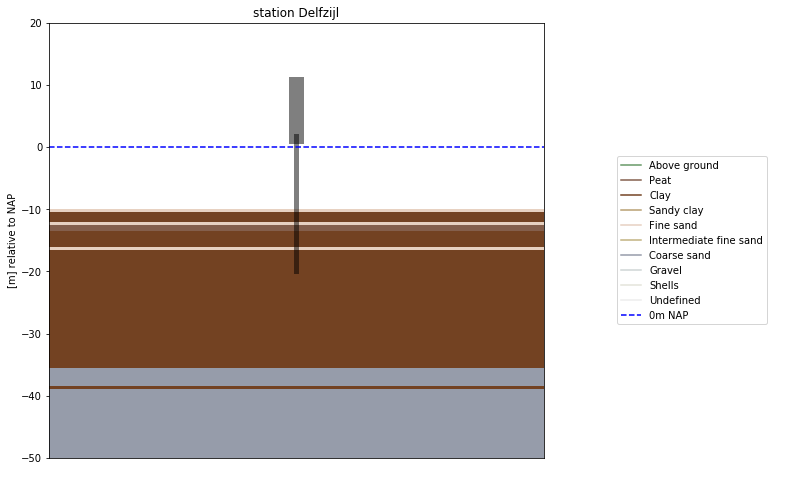

In [22]:
station = 'DELFZL'
IPython.display.display(summary(station))
plot_station(station)




<h2>Den Helder <a id="Index(['Coordinatenstelsel', 'Locatie_MessageID', 'Naam', 'X', 'Y', 'autocad',
       'foundation_low', 'img', 'links', 'location', 'nulpaal', 'psmsl_id',
       'rlr2nap', 'station_high', 'station_low', 'summary', 'psmsl_img',
       'psmsl_info', 'x_rd', 'y_rd', 'lon', 'lat', 'x_webm', 'y_webm',
       'dino_idx', 'x_dino', 'y_dino', 'x_dino_webm', 'y_dino_webm', 'lithok',
       'nap', 'ahn'],
      dtype='object')"></a></h2>

<style>
.right.template {
  float: right;
}
.template img {
  max-width: 300px !important;
}
</style>
<figure class="right template" >
    <img src="http://www.openearth.nl/sealevel/static/images/DENHDR.jpg" />
    <figcaption>Photo of tide gauge at Den Helder, &copy; CIV, RWS</figcaption>
</figure>

<dl>
<dt>Location (lat, lon)</dt>
<dd>52.964, 4.745</dd>
<dt>Location (Rijksdriehoek)</dt>
<dd>111850, 553230</dd>
<dt>PSMSL-ID</dt>
<dd><a href="http://www.psmsl.org/data/obtaining/stations/23.php">23</a></dd>
<dt>Description</dt>
<dd>This station is located in the dike of Den Helder. The station has a pipe through the dike towards the sea for the measurement of the water level. The inlet of this pipe is at -3.25m NAP. There is a seperate construction for the ventilation of the main building. Furthermore the peilbout is located outside the main building at the opposite side of the dike. The main construction has a foundation of steel sheet pilings forming a rectangle around the measurement instruments. Between -4 and -5 m depth concrete seals of the underwater chamber. </dd>
<dt>History</dt>
<dd><pre>Add 6.929m to data up to 2005 to refer to RLR (2007)
Add 6.946m to data 2005 onwards to refer to RLR (2007)
RLR (2007) is 13.2m below TGBM
</pre></dd>
<dt>Nap info (public)</dt>
<dd><pre>
KNOP OP NOHK PEILSCHAALKELDER @ 7.672 (class: 2, distance: 143m)
KNOP OP NWHK PEILSCHAAL KELDER @ 7.688 (class: 2, distance: 143m)
PEILSCHAALHUISJE DEN HELDER @ 1.615 (class: 2, distance: 148m)
GB "DE SCHAAPSKOOI" SCHAPENDIJKJE 6 @ 0.934 (class: 2, distance: 333m)
VM RAADHS DEN HELDER @ 1.345 (class: 2, distance: 615m)
</pre></dd>
</dl>
<h2>Subsidence info</h2>
These are the estimated subsidence rates, based on the NAP history analysis in this repository and on the subsidence report of Hijma (2017). 
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>DENHDR</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Tectonic [cm/year]</th>
      <td>-0.002</td>
    </tr>
    <tr>
      <th>Autocompaction [cm/year]</th>
      <td>-0.004</td>
    </tr>
    <tr>
      <th>Isostacy [cm/year]</th>
      <td>-0.050</td>
    </tr>
    <tr>
      <th>Settlement [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Water extraction [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Salt extraction [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Gas extraction [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Expected water extraction [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Expected salt extraction [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Expected gas extraction [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Subsidence 1890-2017 [cm]</th>
      <td>-7.112</td>
    </tr>
    <tr>
      <th>Expected subsidence 2017-2050</th>
      <td>-1.848</td>
    </tr>
  </tbody>
</table>
Other relevant links:
- <a href='http://a360.co/2s8ltK7'>Autocad drawing</a> of the construction.


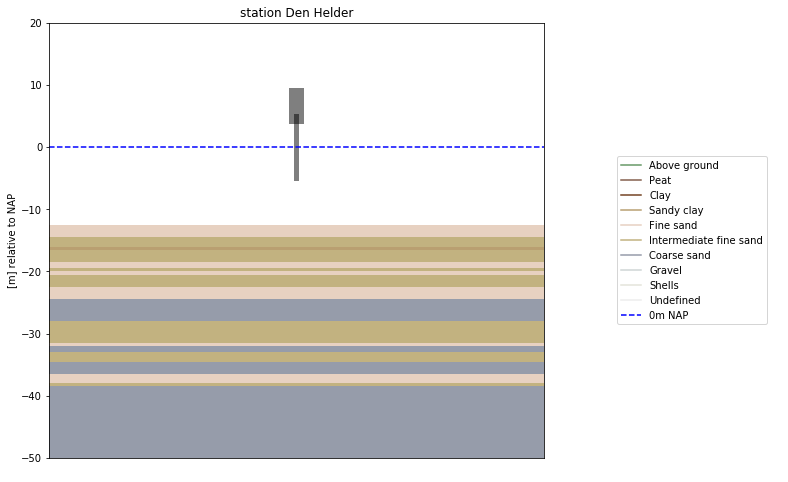

In [23]:
station = 'DENHDR'
IPython.display.display(summary(station))
plot_station(station)




<h2>Harlingen <a id="Index(['Coordinatenstelsel', 'Locatie_MessageID', 'Naam', 'X', 'Y', 'autocad',
       'foundation_low', 'img', 'links', 'location', 'nulpaal', 'psmsl_id',
       'rlr2nap', 'station_high', 'station_low', 'summary', 'psmsl_img',
       'psmsl_info', 'x_rd', 'y_rd', 'lon', 'lat', 'x_webm', 'y_webm',
       'dino_idx', 'x_dino', 'y_dino', 'x_dino_webm', 'y_dino_webm', 'lithok',
       'nap', 'ahn'],
      dtype='object')"></a></h2>

<style>
.right.template {
  float: right;
}
.template img {
  max-width: 300px !important;
}
</style>
<figure class="right template" >
    <img src="http://www.openearth.nl/sealevel/static/images/DELFZL.jpg" />
    <figcaption>Photo of tide gauge at Harlingen, &copy; CIV, RWS</figcaption>
</figure>

<dl>
<dt>Location (lat, lon)</dt>
<dd>53.176, 5.409</dd>
<dt>Location (Rijksdriehoek)</dt>
<dd>156480, 576550</dd>
<dt>PSMSL-ID</dt>
<dd><a href="http://www.psmsl.org/data/obtaining/stations/25.php">25</a></dd>
<dt>Description</dt>
<dd>The tidal station in Harlingen is located in a harbour on top of a boulevard. A pipe is going from the station at a depth of -2.56m NAP towards the sea. The inlet of the pipe is protected by a construction, so as to reduce the variations by the wave impact. The Main building has a foundation of a steel sheet pilings construction (rectangle inner dimensions 2.53 by 2.27m^2) surrounding the measurement instruments.</dd>
<dt>History</dt>
<dd><pre>Add 6.907m to data up to 2005 to refer to RLR (2007)
Add 6.914m to data 2005 onwards to refer to RLR (2007)
RLR (2007) is 13.9m below TGBM
</pre></dd>
<dt>Nap info (public)</dt>
<dd><pre>
PSHS RWS W-Z WADDENPROMENADE 9 @ 6.125 (class: 2, distance: 94m)
TOREN HAVENWACHT @ 6.454 (class: 2, distance: 140m)
TRAFO NIEUWE WILLEMSKD 5 @ 3.955 (class: 2, distance: 546m)
WK HAVENW 69 @ 3.392 (class: 2, distance: 606m)
WK BROUWERSSTR 8 @ 1.715 (class: 2, distance: 699m)
</pre></dd>
</dl>
<h2>Subsidence info</h2>
These are the estimated subsidence rates, based on the NAP history analysis in this repository and on the subsidence report of Hijma (2017). 
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>HARLGN</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Tectonic [cm/year]</th>
      <td>-0.006</td>
    </tr>
    <tr>
      <th>Autocompaction [cm/year]</th>
      <td>-0.004</td>
    </tr>
    <tr>
      <th>Isostacy [cm/year]</th>
      <td>-0.055</td>
    </tr>
    <tr>
      <th>Settlement [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Water extraction [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Salt extraction [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Gas extraction [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Expected water extraction [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Expected salt extraction [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Expected gas extraction [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Subsidence 1890-2017 [cm]</th>
      <td>-8.255</td>
    </tr>
    <tr>
      <th>Expected subsidence 2017-2050</th>
      <td>-2.145</td>
    </tr>
  </tbody>
</table>
Other relevant links:
- <a href='http://a360.co/2s8ltK7'>Autocad drawing</a> of the construction.


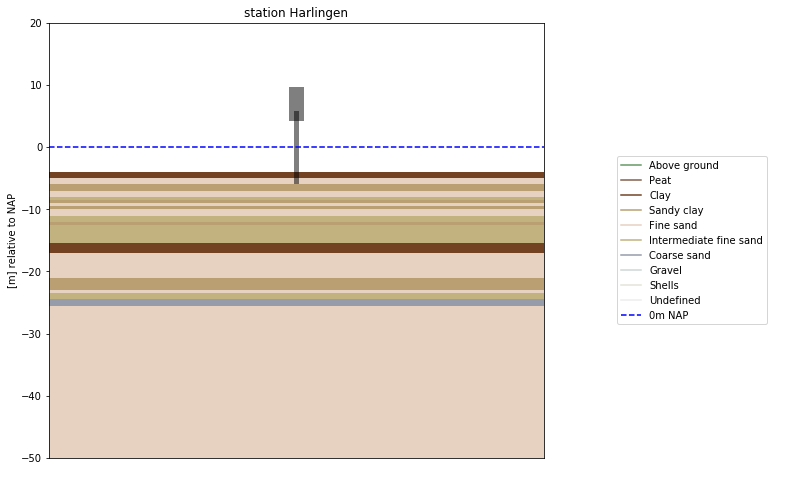

In [24]:
station = 'HARLGN'
IPython.display.display(summary(station))
plot_station(station)




<h2>Hoek van Holland <a id="Index(['Coordinatenstelsel', 'Locatie_MessageID', 'Naam', 'X', 'Y', 'autocad',
       'foundation_low', 'img', 'links', 'location', 'nulpaal', 'psmsl_id',
       'rlr2nap', 'station_high', 'station_low', 'summary', 'psmsl_img',
       'psmsl_info', 'x_rd', 'y_rd', 'lon', 'lat', 'x_webm', 'y_webm',
       'dino_idx', 'x_dino', 'y_dino', 'x_dino_webm', 'y_dino_webm', 'lithok',
       'nap', 'ahn'],
      dtype='object')"></a></h2>

<style>
.right.template {
  float: right;
}
.template img {
  max-width: 300px !important;
}
</style>
<figure class="right template" >
    <img src="http://www.openearth.nl/sealevel/static/images/HOEKVHLD.jpg" />
    <figcaption>Photo of tide gauge at Hoek van Holland, &copy; CIV, RWS</figcaption>
</figure>

<dl>
<dt>Location (lat, lon)</dt>
<dd>51.978, 4.120</dd>
<dt>Location (Rijksdriehoek)</dt>
<dd>67930, 444000</dd>
<dt>PSMSL-ID</dt>
<dd><a href="http://www.psmsl.org/data/obtaining/stations/22.php">22</a></dd>
<dt>Description</dt>
<dd>The station in Hoek van Holland is located beside the Nieuwe Waterweg near the river mouth into the North Sea. The reference pole is situated outside the main building on the main land. The main building is connected to the main land by a steel bridge. The foundation of the main building is on steel poles. The building is a concrete structure reaching to a depth of -3.0 m NAP. This entire thing is enough for the measurement instruments to be placed inside. And the underwater chamber is then, in contrary to the other stations within the main building. The entire concrete structure has a foundation of multiple sheet piles. These are 8 concrete plates (8-sided) with a length of 14.1m. </dd>
<dt>History</dt>
<dd><pre>Add 6.845m to data up to 2005 to refer to RLR (2007)
Add 6.873 to data 2005 onwards to refer to RLR (2007)
RLR (2007) is 11.7m below TGBM
</pre></dd>
<dt>Nap info (public)</dt>
<dd><pre>
BT IN BETON. FUNDERING TRAP PEILHUIS @ 4.333 (class: 2, distance: 10m)
TRAFO R/V W-INGANG RWS-TERREIN BERGHAVEN @ 4.434 (class: 2, distance: 141m)
KNT RWS,STATIONSW 61 @ 6.99 (class: 2, distance: 331m)
STATIONSWG 132 @ 8.047 (class: 2, distance: 469m)
GRONDANKER 25M ZW KONINGIN EMMABOULEVARD                                        (RD-PUNT 379346-11) @ 7.163 (class: 2, distance: 524m)
</pre></dd>
</dl>
<h2>Subsidence info</h2>
These are the estimated subsidence rates, based on the NAP history analysis in this repository and on the subsidence report of Hijma (2017). 
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>HOEKVHLD</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Tectonic [cm/year]</th>
      <td>-0.001</td>
    </tr>
    <tr>
      <th>Autocompaction [cm/year]</th>
      <td>-0.007</td>
    </tr>
    <tr>
      <th>Isostacy [cm/year]</th>
      <td>-0.035</td>
    </tr>
    <tr>
      <th>Settlement [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Water extraction [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Salt extraction [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Gas extraction [cm]</th>
      <td>-2.000</td>
    </tr>
    <tr>
      <th>Expected water extraction [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Expected salt extraction [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Expected gas extraction [cm]</th>
      <td>-1.000</td>
    </tr>
    <tr>
      <th>Subsidence 1890-2017 [cm]</th>
      <td>-7.461</td>
    </tr>
    <tr>
      <th>Expected subsidence 2017-2050</th>
      <td>-2.419</td>
    </tr>
  </tbody>
</table>
Other relevant links:
- <a href='http://a360.co/2s8ltK7'>Autocad drawing</a> of the construction.


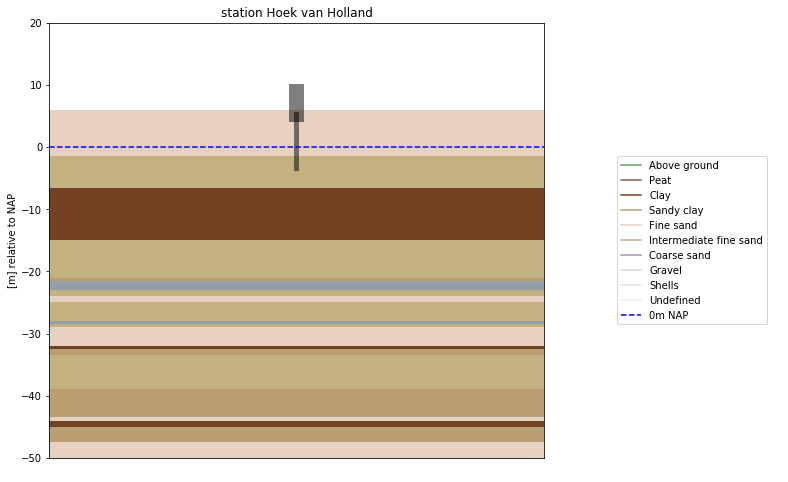

In [25]:
station = 'HOEKVHLD'
IPython.display.display(summary(station))
plot_station(station)




<h2>IJmuiden <a id="Index(['Coordinatenstelsel', 'Locatie_MessageID', 'Naam', 'X', 'Y', 'autocad',
       'foundation_low', 'img', 'links', 'location', 'nulpaal', 'psmsl_id',
       'rlr2nap', 'station_high', 'station_low', 'summary', 'psmsl_img',
       'psmsl_info', 'x_rd', 'y_rd', 'lon', 'lat', 'x_webm', 'y_webm',
       'dino_idx', 'x_dino', 'y_dino', 'x_dino_webm', 'y_dino_webm', 'lithok',
       'nap', 'ahn'],
      dtype='object')"></a></h2>

<style>
.right.template {
  float: right;
}
.template img {
  max-width: 300px !important;
}
</style>
<figure class="right template" >
    <img src="http://www.openearth.nl/sealevel/static/images/IJMDBTHVN.jpg" />
    <figcaption>Photo of tide gauge at IJmuiden, &copy; CIV, RWS</figcaption>
</figure>

<dl>
<dt>Location (lat, lon)</dt>
<dd>52.462, 4.555</dd>
<dt>Location (Rijksdriehoek)</dt>
<dd>98430, 497500</dd>
<dt>PSMSL-ID</dt>
<dd><a href="http://www.psmsl.org/data/obtaining/stations/32.php">32</a></dd>
<dt>Description</dt>
<dd>IJmuiden is located on the northern part of the marina in IJmuiden, near a breakwater. The main building is situated in the water and is connected by a steel stairs and bridge with the main land. The foundation of this building consists out a round steel sheet pile. The under water chamber is closed of with a concrete slab between -3.75m NAP and - 4.5m NAP. The sheet pile is extended to a depth of -13m NAP. IJmuiden has a GPS (GNSS) station attached to it.</dd>
<dt>History</dt>
<dd><pre>Add 6.929m to data up to 2005 to refer to RLR (2007)
Add 6.950m to data 2005 onwards to refer to RLR (2007)
RLR (2007) is 11.4m below TGBM
</pre></dd>
<dt>Nap info (public)</dt>
<dd><pre>
LICHTBUNKER OP OUDE GED. Z-PIER @ 4.484 (class: 2, distance: 10m)
N-HEKPOER V/D Z-PIER @ 5.003 (class: 2, distance: 108m)
BOVENKANT Z-PIER, 0.95 M U/D Z-MR RD=   240323-11 @ 4.62 (class: 2, distance: 114m)
TRAFO KENNEMERBOULEVARD 3\t @ 4.13 (class: 2, distance: 338m)
LICHTBUNKER OP OUDE GED. N-PIER @ 6.447 (class: 2, distance: 483m)
</pre></dd>
</dl>
<h2>Subsidence info</h2>
These are the estimated subsidence rates, based on the NAP history analysis in this repository and on the subsidence report of Hijma (2017). 
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>IJMDBTHVN</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Tectonic [cm/year]</th>
      <td>-0.006</td>
    </tr>
    <tr>
      <th>Autocompaction [cm/year]</th>
      <td>-0.008</td>
    </tr>
    <tr>
      <th>Isostacy [cm/year]</th>
      <td>-0.040</td>
    </tr>
    <tr>
      <th>Settlement [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Water extraction [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Salt extraction [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Gas extraction [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Expected water extraction [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Expected salt extraction [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Expected gas extraction [cm]</th>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Subsidence 1890-2017 [cm]</th>
      <td>-6.858</td>
    </tr>
    <tr>
      <th>Expected subsidence 2017-2050</th>
      <td>-1.782</td>
    </tr>
  </tbody>
</table>
Other relevant links:
- <a href='http://a360.co/2s8ltK7'>Autocad drawing</a> of the construction.


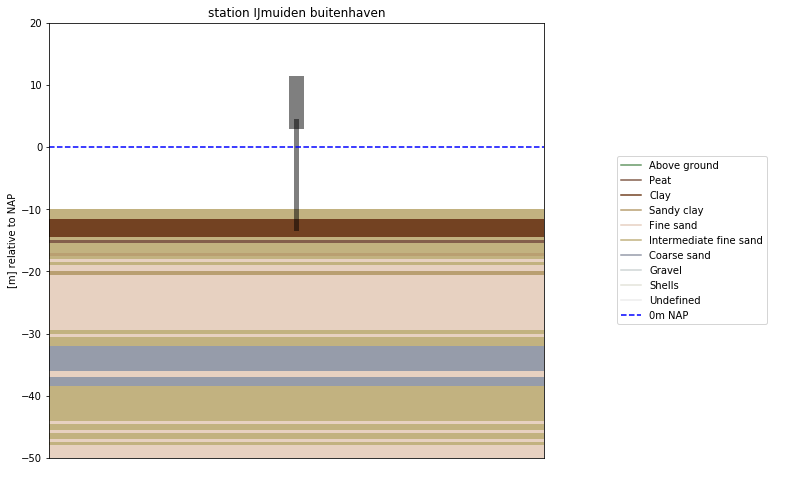

In [26]:
station = 'IJMDBTHVN'
IPython.display.display(summary(station))
plot_station(station)




<h2>Vlissingen <a id="Index(['Coordinatenstelsel', 'Locatie_MessageID', 'Naam', 'X', 'Y', 'autocad',
       'foundation_low', 'img', 'links', 'location', 'nulpaal', 'psmsl_id',
       'rlr2nap', 'station_high', 'station_low', 'summary', 'psmsl_img',
       'psmsl_info', 'x_rd', 'y_rd', 'lon', 'lat', 'x_webm', 'y_webm',
       'dino_idx', 'x_dino', 'y_dino', 'x_dino_webm', 'y_dino_webm', 'lithok',
       'nap', 'ahn'],
      dtype='object')"></a></h2>

<style>
.right.template {
  float: right;
}
.template img {
  max-width: 300px !important;
}
</style>
<figure class="right template" >
    <img src="http://www.openearth.nl/sealevel/static/images/VLISSGN.jpg" />
    <figcaption>Photo of tide gauge at Vlissingen, &copy; CIV, RWS</figcaption>
</figure>

<dl>
<dt>Location (lat, lon)</dt>
<dd>51.442, 3.596</dd>
<dt>Location (Rijksdriehoek)</dt>
<dd>30480, 385220</dd>
<dt>PSMSL-ID</dt>
<dd><a href="http://www.psmsl.org/data/obtaining/stations/20.php">20</a></dd>
<dt>Description</dt>
<dd>This station is located at a quay in Vlissingen, near the outer harbour. The foundation is a steel sheet pile reaching to a depth of -17.6m NAP, having a width of 2.2m (outer width). Inside this pile are the measurement instruments. The under water chamber is sealed of with a concrete slab reaching from -4.0 m NAP to -5.0 m NAP. The station has a GPS (GNSS) device attached.</dd>
<dt>History</dt>
<dd><pre>Add 6.900m to data up to 2005 to refer to RLR (2007)
Add 6.930m to data 2005 onwards to refer to RLR (2007)
RLR (2007) is 11.6m below TGBM
</pre></dd>
<dt>Nap info (public)</dt>
<dd><pre>
PEILSCHAALSTATION @ 4.949 (class: 2, distance: 108m)
HOGE BT MUUR OUDE VEERHAVEN N PEILSCHAA @ 4.877 (class: 2, distance: 128m)
FIETSENSTALLING STATION NS @ 4.923 (class: 2, distance: 215m)
KNT GB STEENKOOL HANDELS VERG: O-INGANG BUITENHAVEN @ 4.99 (class: 2, distance: 533m)
ZO-Z BUNKER, W-GED. VAN VOORM. FORT 'DE RUIJTER' @ 3.214 (class: 2, distance: 868m)
</pre></dd>
</dl>
<h2>Subsidence info</h2>
These are the estimated subsidence rates, based on the NAP history analysis in this repository and on the subsidence report of Hijma (2017). 
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>VLISSGN</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Tectonic [cm/year]</th>
      <td>0.0005</td>
    </tr>
    <tr>
      <th>Autocompaction [cm/year]</th>
      <td>0.0000</td>
    </tr>
    <tr>
      <th>Isostacy [cm/year]</th>
      <td>-0.0250</td>
    </tr>
    <tr>
      <th>Settlement [cm]</th>
      <td>0.0000</td>
    </tr>
    <tr>
      <th>Water extraction [cm]</th>
      <td>0.0000</td>
    </tr>
    <tr>
      <th>Salt extraction [cm]</th>
      <td>0.0000</td>
    </tr>
    <tr>
      <th>Gas extraction [cm]</th>
      <td>0.0000</td>
    </tr>
    <tr>
      <th>Expected water extraction [cm]</th>
      <td>0.0000</td>
    </tr>
    <tr>
      <th>Expected salt extraction [cm]</th>
      <td>0.0000</td>
    </tr>
    <tr>
      <th>Expected gas extraction [cm]</th>
      <td>0.0000</td>
    </tr>
    <tr>
      <th>Subsidence 1890-2017 [cm]</th>
      <td>-3.1115</td>
    </tr>
    <tr>
      <th>Expected subsidence 2017-2050</th>
      <td>-0.8085</td>
    </tr>
  </tbody>
</table>
Other relevant links:
- <a href='http://a360.co/2s8ltK7'>Autocad drawing</a> of the construction.


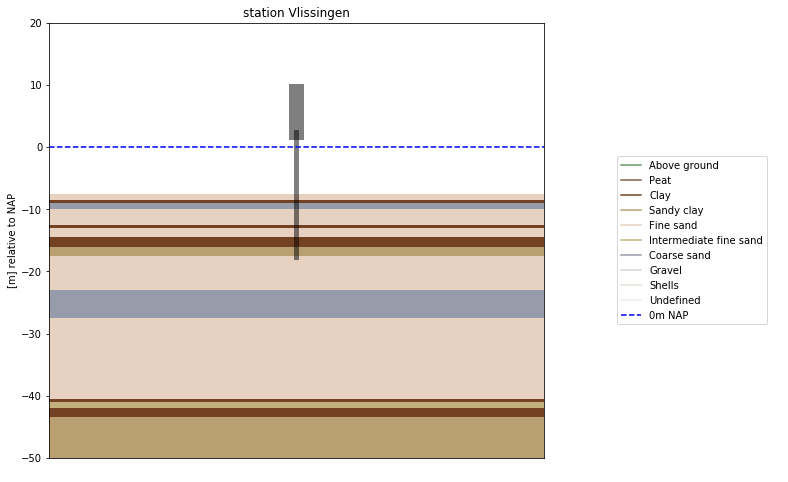

In [27]:
station = 'VLISSGN' 
IPython.display.display(summary(station))
plot_station(station)

# Side view of the subsoil
This map below shows a map of the subsoil. The subsoil is raised by 50m out of the ground. You can rotate, skew and zoom using a combination of mouse buttons.

In [28]:
%%html
<iframe src="https://api.mapbox.com/styles/v1/camvdvries/cj4o674wv8i9j2rs30ew26vm1.html?fresh=true&title=true&access_token=pk.eyJ1IjoiY2FtdmR2cmllcyIsImEiOiJjajA4NXdpNmswMDB2MzNzMjk4dGM2cnhzIn0.lIwd8N7wf0hx7mq-kjTcbQ#13.4/52.0524/4.1907/83.8/60" 
style="width: 100%; height: 500px;"/>